# USA Private Markets Macro Correlations

This notebook loads processed monthly returns and feature matrices, computes correlations, and visualizes key relationships between private markets proxies and macro factors.

## Setup

Make sure you've run the pipeline first:
```bash
python scripts/run_full_pipeline.py
```

Or at least steps 1 and 2:
```bash
python scripts/01_download_data.py
python scripts/02_prepare_data.py
```

In [ ]:
import sys
import pandas as pd
from pathlib import Path

# Add project root to path so we can import from src
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

from src import analysis, plotting

# Load data from parent directory
data_dir = project_root / 'data_processed'
returns = pd.read_csv(data_dir / 'monthly_returns.csv')
features = pd.read_csv(data_dir / 'features_monthly.csv', index_col=0, parse_dates=True)

print(f"Loaded {len(returns)} return observations")
print(f"Loaded {len(features.columns)} features")

# Static correlations
pe_corr = analysis.compute_static_correlations(returns[returns['group']=='PE'], features, lag=1)
pc_corr = analysis.compute_static_correlations(returns[returns['group']=='PC'], features, lag=1)

print(f"\nComputed correlations for {pe_corr['asset'].nunique()} PE assets and {pc_corr['asset'].nunique()} PC assets")

# Configure matplotlib for inline display
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
print("\n✓ Ready to visualize!")


Loaded 2890 return observations
Loaded 20 features

Computed correlations for 6 PE assets and 6 PC assets

✓ Ready to visualize!


Private Equity - Macro Correlations (1-month lag)


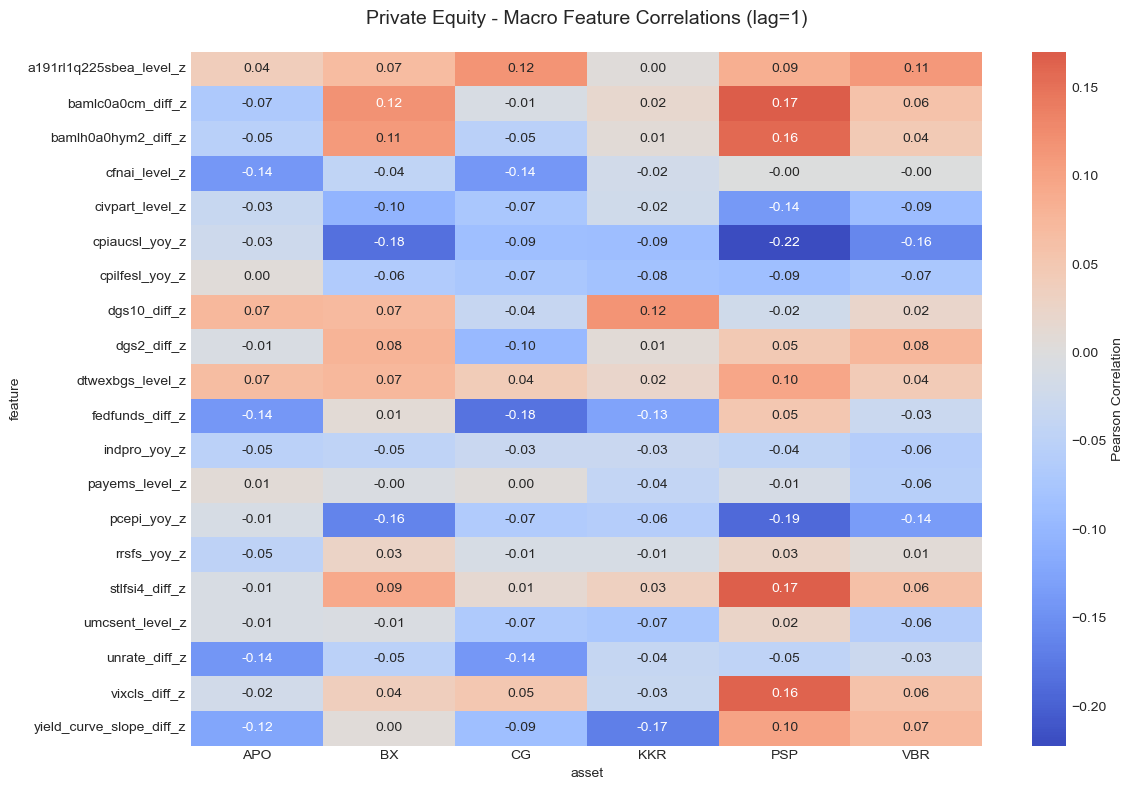


Private Credit - Macro Correlations (1-month lag)


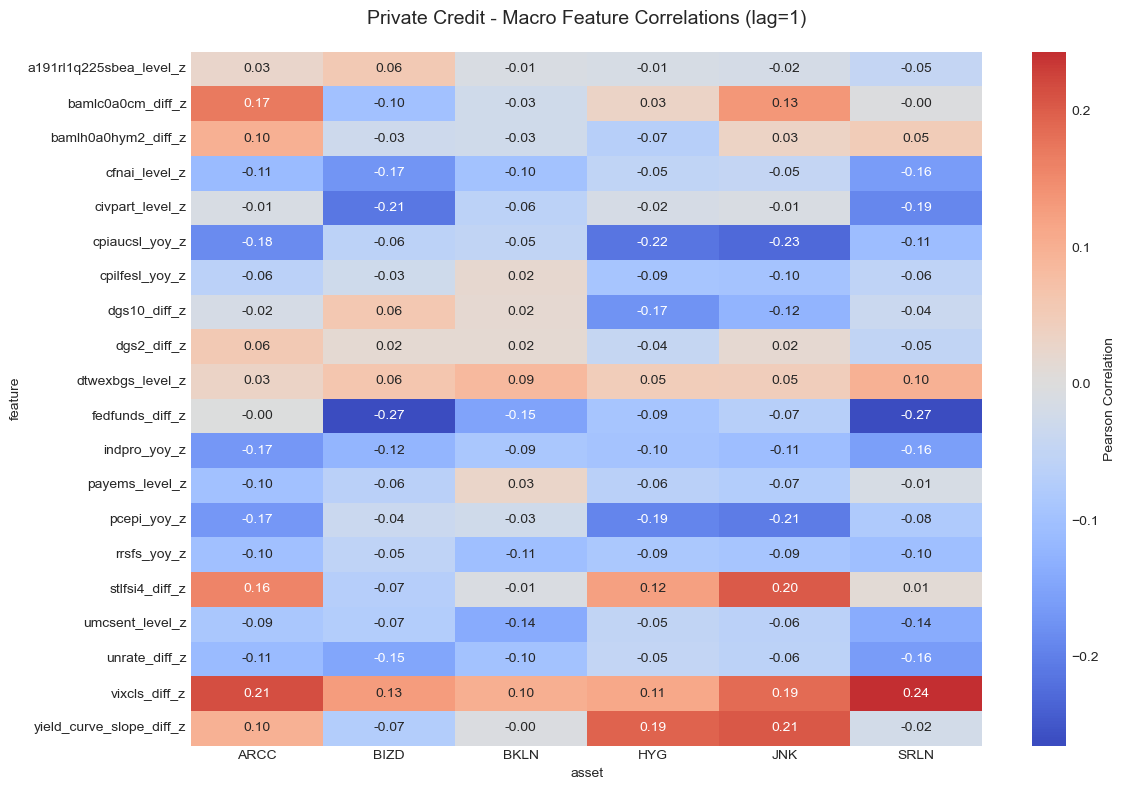

In [ ]:
# Plot correlation heatmaps
import matplotlib.pyplot as plt
import seaborn as sns

# Private Equity Correlations
print("Private Equity - Macro Correlations (1-month lag)")
pivot_pe = pe_corr.pivot(index="feature", columns="asset", values="pearson")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_pe, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Pearson Correlation'})
plt.title("Private Equity - Macro Feature Correlations (lag=1)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Private Credit Correlations
print("\nPrivate Credit - Macro Correlations (1-month lag)")
pivot_pc = pc_corr.pivot(index="feature", columns="asset", values="pearson")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_pc, annot=True, fmt=".2f", cmap="coolwarm", center=0, cbar_kws={'label': 'Pearson Correlation'})
plt.title("Private Credit - Macro Feature Correlations (lag=1)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## Rolling Correlations & Scatter Examples
Use the helper functions for specific asset-feature pairs. Modify the tickers/features as needed.

Rolling 36-month correlation: BX vs bamlh0a0hym2_diff_z


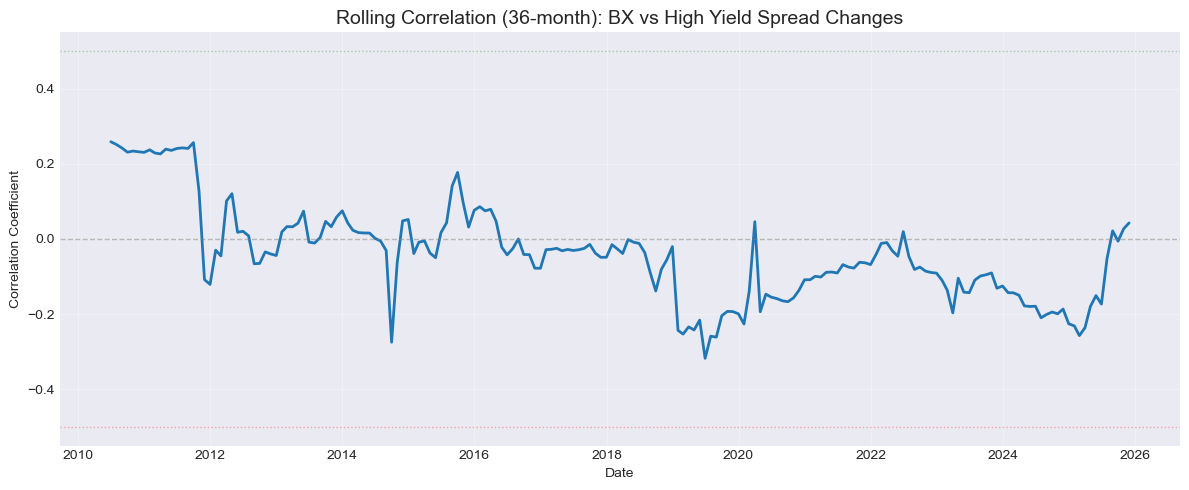

In [ ]:
# Example: BX vs High Yield Spreads
asset = 'BX'
feature = 'bamlh0a0hym2_diff_z'

print(f"Rolling 36-month correlation: {asset} vs {feature}")
rolling = analysis.compute_rolling_correlations(returns, features, asset=asset, feature=feature, window=36, lag=1)

if not rolling.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(rolling.index, rolling.values, linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    plt.axhline(0.5, color='green', linestyle=':', linewidth=1, alpha=0.3)
    plt.axhline(-0.5, color='red', linestyle=':', linewidth=1, alpha=0.3)
    plt.title(f"Rolling Correlation (36-month): {asset} vs High Yield Spread Changes", fontsize=14)
    plt.ylabel("Correlation Coefficient")
    plt.xlabel("Date")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data for rolling correlation")

Scatter plot: BX returns vs bamlh0a0hym2_diff_z


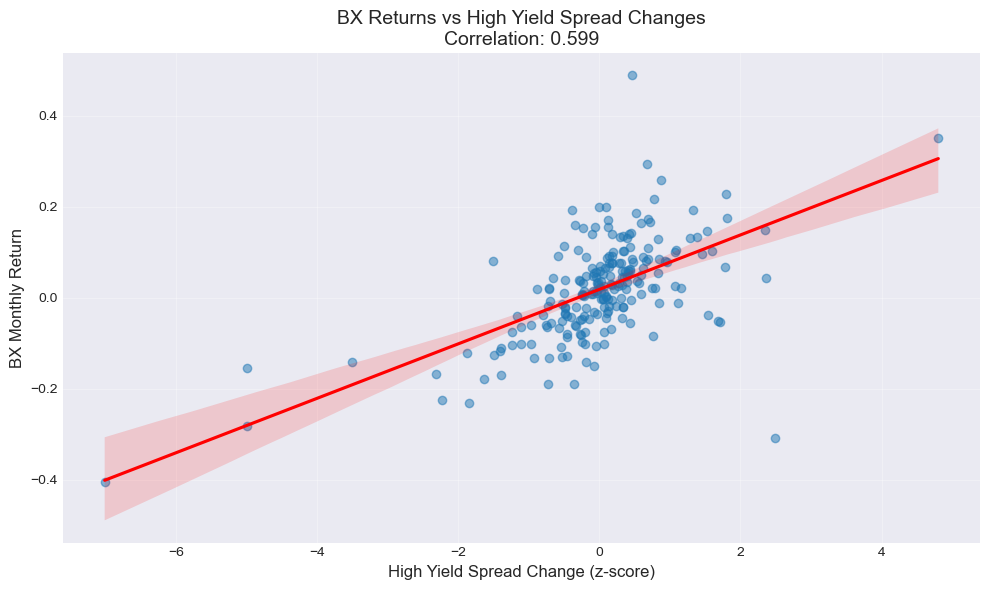

Correlation: 0.599
Observations: 221


In [ ]:
# Scatter plot: BX returns vs High Yield Spread changes
print(f"Scatter plot: {asset} returns vs {feature}")

feature_series = features[feature]
asset_series = returns[returns['ticker']==asset].set_index('date')['return']
feature_series.index = pd.to_datetime(feature_series.index)
asset_series.index = pd.to_datetime(asset_series.index)

# Align the series
aligned = pd.concat([asset_series, feature_series], axis=1).dropna()
aligned.columns = ['return', 'feature']

if len(aligned) > 10:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='feature', y='return', data=aligned, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    
    # Calculate correlation
    corr = aligned['return'].corr(aligned['feature'])
    plt.title(f"{asset} Returns vs High Yield Spread Changes\nCorrelation: {corr:.3f}", fontsize=14)
    plt.xlabel("High Yield Spread Change (z-score)", fontsize=12)
    plt.ylabel(f"{asset} Monthly Return", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Correlation: {corr:.3f}")
    print(f"Observations: {len(aligned)}")
else:
    print("Not enough data for scatter plot")

## Takeaways and Next Steps

### Key Questions to Explore:

1. **Which macro factors show the strongest correlations?**
   - Look at the heatmaps above for the highest absolute correlation values
   - Compare PE vs PC sensitivities

2. **Are correlations stable over time?**
   - Check the rolling correlation plots for time variation
   - Look for structural breaks or regime changes

3. **Do macro variables lead or lag asset returns?**
   - Compare lag=0 vs lag=1 correlations
   - Useful for understanding if macro data is predictive

### Try Your Own Analysis:

Change the `asset` and `feature` variables in the cells above to explore other relationships. Examples:

**Private Equity Assets:**
- PSP, BX, KKR, APO, CG, VBR

**Private Credit Assets:**
- HYG, JNK, BKLN, SRLN, BIZD, ARCC

**Key Macro Features:**
- `a191rl1q225sbea_level_z` - GDP growth
- `bamlh0a0hym2_diff_z` - High yield spreads  
- `fedfunds_diff_z` - Fed funds rate changes
- `stlfsi4_diff_z` - Financial stress
- `vixcls_diff_z` - VIX changes
- `unrate_diff_z` - Unemployment changes

See `DATA_DICTIONARY.md` for complete list of variables!